In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

In [2]:
pipeline  = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

In [3]:
train_dataset = datasets.MNIST( './data',train = True,transform = pipeline,download=True )
test_dataset = datasets.MNIST('./data',train = False,transform = pipeline,download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.15MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.56MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_loader = DataLoader(train_dataset,batch_size = 64,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = 64,shuffle = True)

In [19]:
class Network(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = torch.nn.Linear(784,512)
    self.hidden2 = torch.nn.Linear(512,256)
    self.hidden3 = torch.nn.Linear(256,128)
    self.output = torch.nn.Linear(128,10)
    self.dropout = torch.nn.Dropout(p=0.2)
  def forward(self,x):

    x = self.dropout(F.relu(self.hidden1(x)))
    x = self.dropout(F.relu(self.hidden2(x)))
    x = self.dropout(F.relu(self.hidden3(x)))
    x = F.log_softmax(self.output(x),dim=1)
    return x

In [20]:
#defining Model
model = Network()

In [13]:
#loss function
loss = torch.nn.NLLLoss()

In [21]:
#Optimizer function
optimizer = optim.SGD(model.parameters(), 0.01)

In [22]:
epochs = 16
tloss = []
vloss = []
for e in range(epochs):
  running_loss = 0
  accuracy = 0
  for image,label in(train_loader):
    flat_img = image.view(image.shape[0],-1)
    output = model.forward(flat_img)

    #removing previous grads
    optimizer.zero_grad()

    #loss
    error = loss(output,label)

    #backpropogation
    error.backward()

    #optimization
    optimizer.step()

    running_loss +=error.item()
  else:
    test_loss = 0
    model.eval()
    with torch.no_grad():
      for image,label in(test_loader):
        flat_img = image.view(image.shape[0],-1)
        output = model.forward(flat_img)
        error = loss(output,label)
        test_loss +=error.item()
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == label.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    model.train()
  tloss.append(running_loss/len(train_loader))
  vloss.append(test_loss/len(test_loader))
  print(f"Epoch {e+1}/{epochs}.. Training Loss: {running_loss/len(train_loader)}.. Test Loss: {test_loss/len(test_loader)}")
  print("Accuracy: ",accuracy/len(test_loader))

Epoch 1/16.. Training Loss: 1.5503560595357342.. Test Loss: 0.5728949955694235
Accuracy:  tensor(0.8393)
Epoch 2/16.. Training Loss: 0.5357169522754928.. Test Loss: 0.3443749830316586
Accuracy:  tensor(0.8988)
Epoch 3/16.. Training Loss: 0.40111171225431375.. Test Loss: 0.28893612439085725
Accuracy:  tensor(0.9130)
Epoch 4/16.. Training Loss: 0.33774530862980306.. Test Loss: 0.24651861703319913
Accuracy:  tensor(0.9269)
Epoch 5/16.. Training Loss: 0.2918134624325136.. Test Loss: 0.21542310728958458
Accuracy:  tensor(0.9364)
Epoch 6/16.. Training Loss: 0.25422214208317717.. Test Loss: 0.19574093408170778
Accuracy:  tensor(0.9411)
Epoch 7/16.. Training Loss: 0.2259657736986812.. Test Loss: 0.17579781962855226
Accuracy:  tensor(0.9491)
Epoch 8/16.. Training Loss: 0.20408275547915938.. Test Loss: 0.16007574673765784
Accuracy:  tensor(0.9525)
Epoch 9/16.. Training Loss: 0.1850358227939049.. Test Loss: 0.13992914130353623
Accuracy:  tensor(0.9572)
Epoch 10/16.. Training Loss: 0.1672915008459

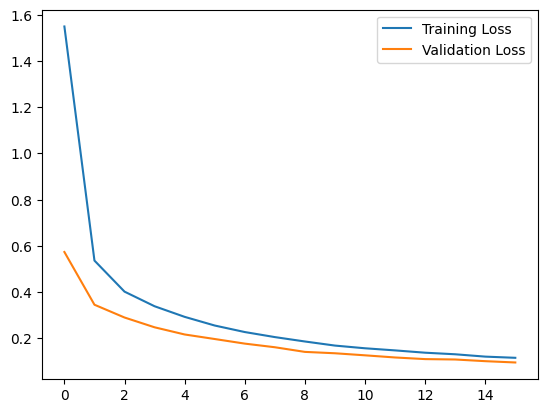

In [23]:
plt.plot(tloss,label='Training Loss')
plt.plot(vloss,label='Validation Loss')
plt.legend()

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
    """Visualizes an image and its predicted probabilities."""
    ps = ps.detach().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), nrows=2)
    ax1.imshow(img.squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))
    ax2.set_yticklabels(np.arange(len(ps)))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()


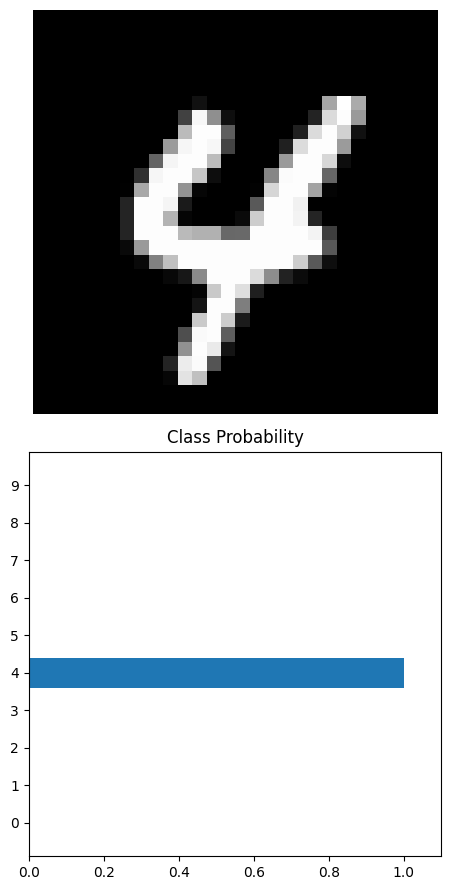

In [26]:
%matplotlib inline
images, labels = next(iter(test_loader))
img = images[1].view(1,784)
with torch.no_grad():
  logps = model(img)
ps = F.softmax(logps,dim=1)

view_classify(img.view(1,28,28),ps)